In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [4]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [5]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

(16,)

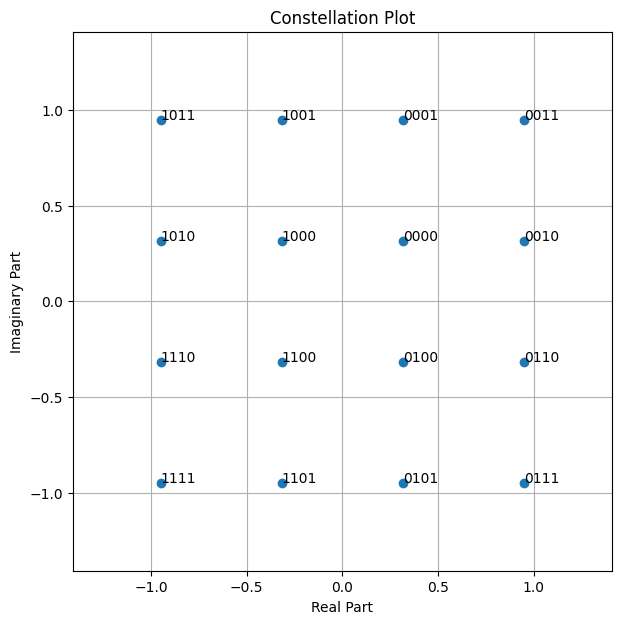

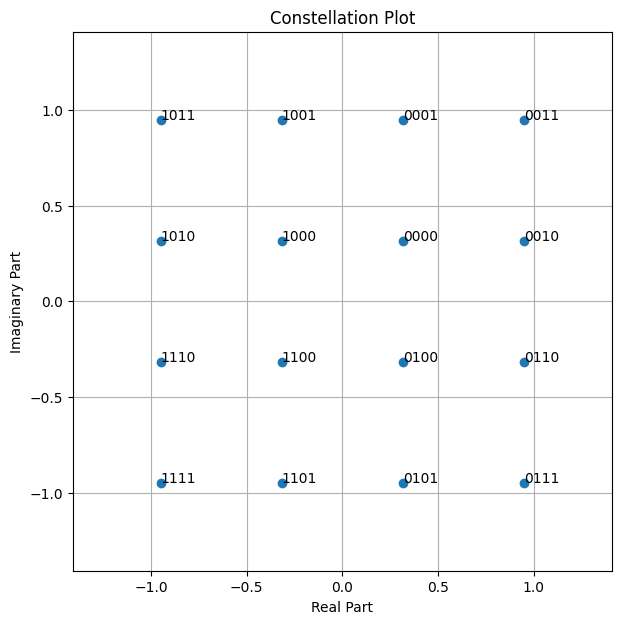

In [6]:
show(points, NUM_BITS_PER_SYMBOL)

In [7]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [8]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [9]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)

    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [10]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [11]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs

    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0)
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch

    def __len__(self):
        return len(self.ebno_dbs)

In [12]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [13]:
onesample = dataset[0]

In [14]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [15]:
onesample['samples'].shape

torch.Size([64, 256])

In [16]:
onesample['labels'].shape

(64, 1024)

In [17]:
# train, validation and test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [18]:
onebatch = next(iter(val_loader))

In [19]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [20]:
onebatch = next(iter(train_loader))

In [21]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [22]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [23]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs #[64, 64, 512]

        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [24]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [25]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [26]:
output.shape

torch.Size([32, 64, 1024])

In [27]:
output.dtype

torch.float32

In [29]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
#--optimizer-1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#--optimizer-2
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#--optimizer-2
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

#added extra for better results
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)

In [30]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [31]:
loss_fn(test,test)

tensor(0.)

In [32]:
onebatch['labels'].dtype

torch.float32

In [33]:
loss_fn(output,onebatch['labels'])

tensor(0.7011, grad_fn=<BinaryCrossEntropyBackward0>)

In [34]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [35]:
train_losses = []
val_losses = []
val_BERs = []

In [36]:
model=model.to(device)

In [39]:
from tqdm.auto import tqdm
import numpy as np

# Initialize lists to store losses and BERs for visualization and analysis
train_losses = []
val_losses = []
val_BERs = []

# Training loop
start_epoch = 0
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)  # Save average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            val_total_loss += val_loss.item()

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / labels.numel()  # Use numel() for total number of elements in labels
            BER_batch.append(error_rate.item())

    # Kapil=Calculate mean validation loss and mean BER for this epoch
    val_loss_mean = val_total_loss / len(val_loader)
    val_losses.append(val_loss_mean)  # Save mean validation loss for this epoch
    BER_batch_mean = np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)  # Save mean BER for this epoch

    # Use the mean validation loss for scheduler step
    scheduler.step(val_loss_mean)

    # Print or log training and validation results after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss_mean:.4f}, Val BER: {BER_batch_mean:.4f}")


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.5810, Val Loss: 0.5768, Val BER: 0.2139


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.5706, Val Loss: 0.5666, Val BER: 0.2127


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.5604, Val Loss: 0.5565, Val BER: 0.2067


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.5501, Val Loss: 0.5462, Val BER: 0.2070


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.5399, Val Loss: 0.5361, Val BER: 0.1990


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.5298, Val Loss: 0.5263, Val BER: 0.1951


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.5198, Val Loss: 0.5162, Val BER: 0.1925


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.5097, Val Loss: 0.5063, Val BER: 0.1900


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.4998, Val Loss: 0.4966, Val BER: 0.1890


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.4907, Val Loss: 0.4885, Val BER: 0.1881


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.4832, Val Loss: 0.4818, Val BER: 0.1878


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.4772, Val Loss: 0.4766, Val BER: 0.1879


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.4722, Val Loss: 0.4723, Val BER: 0.1882


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.4682, Val Loss: 0.4685, Val BER: 0.1883


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.4646, Val Loss: 0.4657, Val BER: 0.1884


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.4618, Val Loss: 0.4629, Val BER: 0.1889


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.4593, Val Loss: 0.4608, Val BER: 0.1889


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.4571, Val Loss: 0.4588, Val BER: 0.1891


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.4553, Val Loss: 0.4573, Val BER: 0.1888


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.4536, Val Loss: 0.4557, Val BER: 0.1884


In [40]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

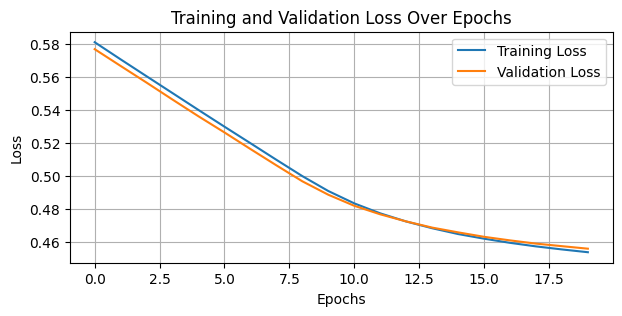

In [41]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

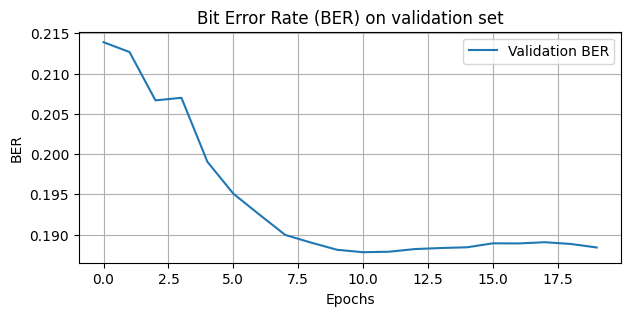

In [42]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [20]:
def load_model(model_path, num_bits_per_symbol):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnhancedSimpleModel4(num_bits_per_symbol=num_bits_per_symbol).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

In [21]:
def evaluate_model_performance(model, num_bits_per_symbol, snr_levels, frame_size=64, blocklength=1024, batch_size=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    snr_to_ber = {}
    for snr in snr_levels:
        dataset = ComplexDataset(num_bits_per_symbol=num_bits_per_symbol, Frame_SIZE=frame_size, Blocklength=blocklength, DB_MIN=snr, DB_MAX=snr, totaldbs=batch_size)
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

        total_errors, total_bits = 0, 0
        with torch.no_grad():
            for data_batch in dataloader:
                samples, labels = data_batch['samples'].to(device), data_batch['labels'].to(device)
                outputs = model(samples)
                predicted_bits = torch.round(outputs)
                total_errors += (predicted_bits != labels).sum().item()
                total_bits += labels.numel()

        ber = total_errors / total_bits
        snr_to_ber[snr] = ber

    return snr_to_ber

In [ ]:
model_path = 'enhanced_model_4.pth'
num_bits_per_symbol = 4  # Example: 4 for 16-QAM
snr_levels = np.linspace(-10, 20, 7)  # Example: from -10 dB to 20 dB, with 10 points

# Load the pre-trained model
model = load_model(model_path, num_bits_per_symbol)

# Evaluate the model's performance
snr_to_ber = evaluate_model_performance(model, num_bits_per_symbol, snr_levels)

plt.figure(figsize=(10, 6))
plt.plot(snr_levels, list(snr_to_ber.values()), marker='o', linestyle='-')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title(f'Performance Evaluation for {num_bits_per_symbol}-bits/symbol')
plt.grid(True)
plt.savefig("enhanced_model_4_BER_vs_SNR_graph.svg", format='svg')